# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [1]:
!git clone -b develop https://github.com/haminhtien99/cvr_course

Cloning into 'cvr_course'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 532 (delta 21), reused 8 (delta 2), pack-reused 491
Receiving objects: 100% (532/532), 67.94 MiB | 30.70 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [2]:
cd cvr_course/notebooks


/content/cvr_course/notebooks


In [69]:
import numpy as np
import cv2
import time
import os
import math
import sys
import glob
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)


##Реализуйте чтение изображений, 

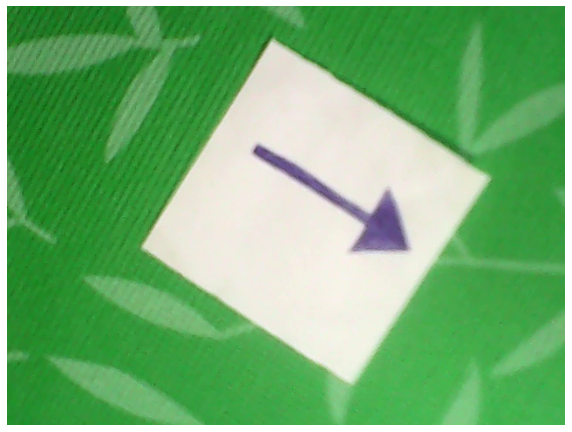

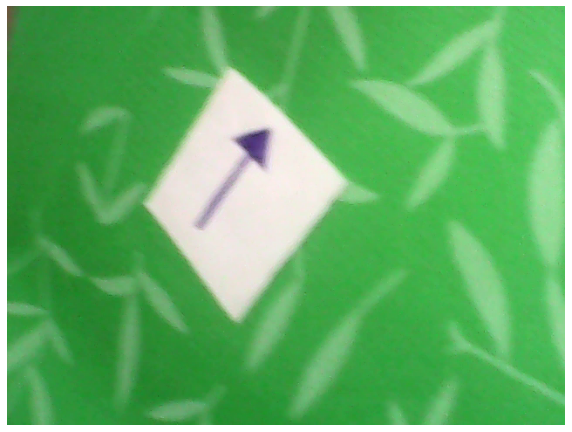

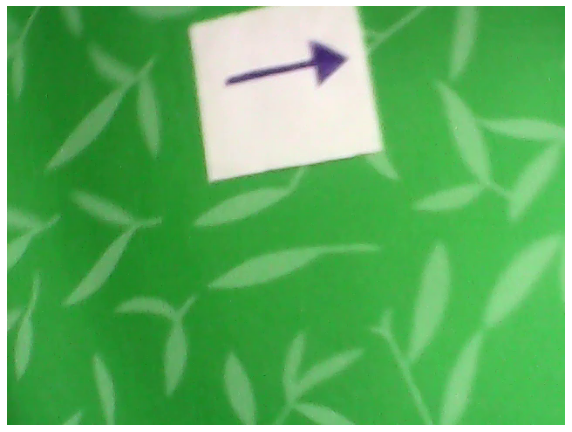

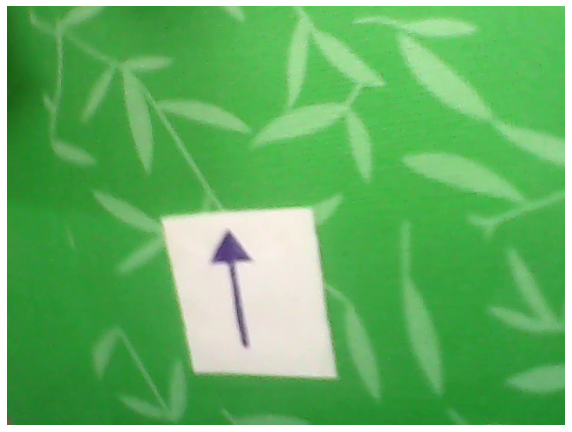

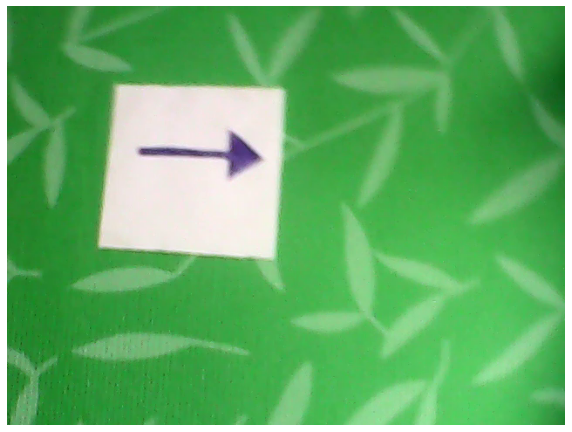

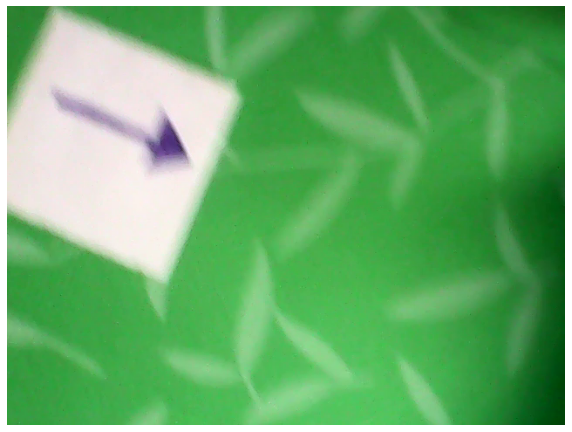

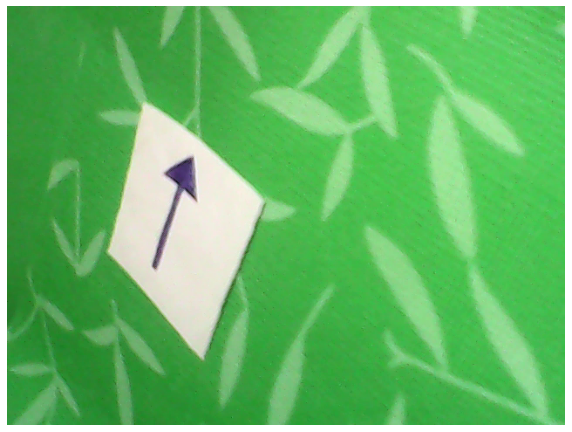

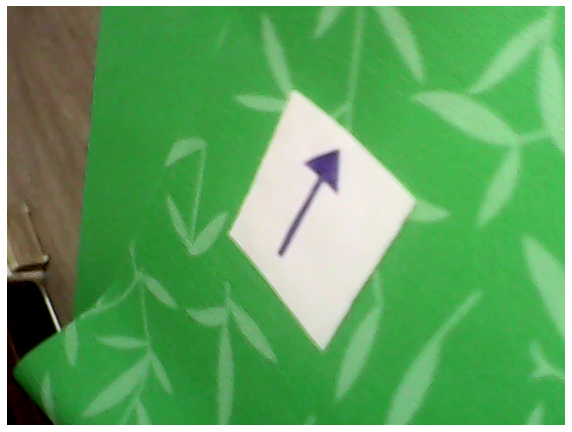

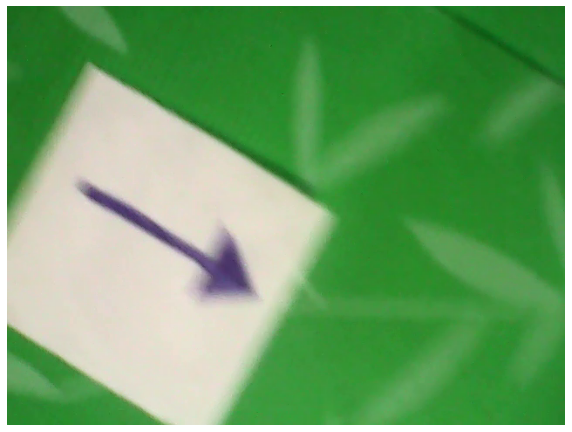

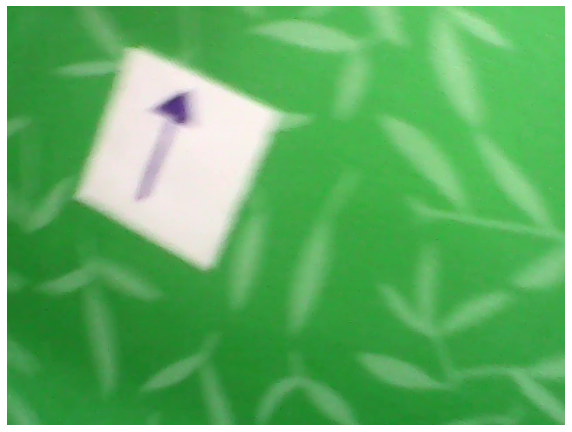

In [12]:
files = glob.glob('../data/imgs/arrow/*.png')
for fname in files:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [9]:
print(files)

['../data/imgs/arrow/vlcsnap-2020-10-21-18h01m49s487.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m29s941.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m41s874.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m33s362.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m44s163.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m46s644.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m22s212.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m27s294.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m51s638.png', '../data/imgs/arrow/vlcsnap-2020-10-21-18h01m36s056.png']


##Find contour


In [28]:

def find_contour (img, low_th, high_th):
    img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.inRange (img, low_th, high_th)
    
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    

    # find largest area contour
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            cnt = contours[i]
            max_area = area

    
    
    approx = cv2.convexHull (cnt)

    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)
    
    return approx

##Реализуйте нахождение расстояния от камеры до листка,

In [29]:
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)

    contour = find_contour (img, low_th, high_th)
    
    length = cv2.arcLength (contour, True)
    
    #print (contour)

    distance = 180.0 * 364 / length
    
    return distance

In [30]:
for fname in files:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    dist = find_distance(img)
    print (dist)

58.213898179172
91.4181030090751
92.1951292094964
95.15204916054759
86.98571825076148
77.07543760345204
96.64850710230294
91.934760625742
66.25763790351805
94.81533612993083


##Points ordering

In [39]:
def order_points(pts):
    
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    pts=np.delete(pts,np.argmax(s),axis=0)
    s = pts.sum(axis=1)
    pts=np.delete(pts,np.argmin(s),axis=0)

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect



##Реализуйте приведение изображения листка к "виду сверху"

In [37]:
def four_point_transform(img, pts):
    
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    
    return warped

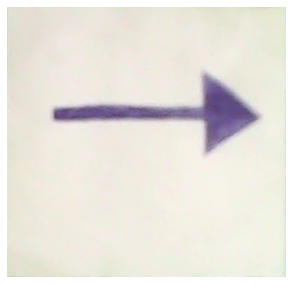

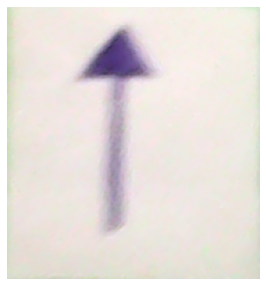

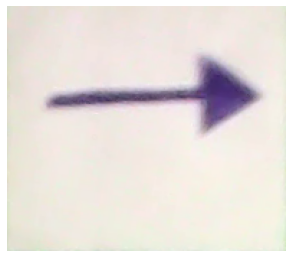

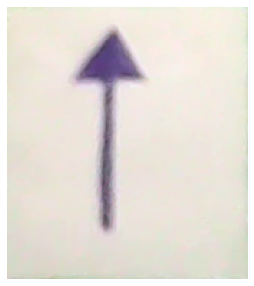

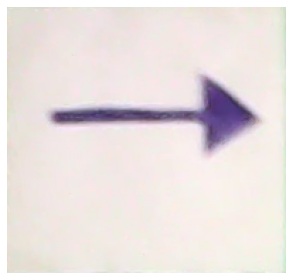

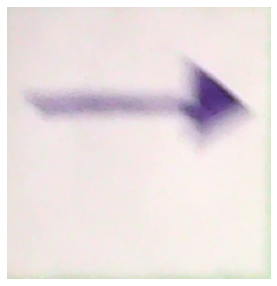

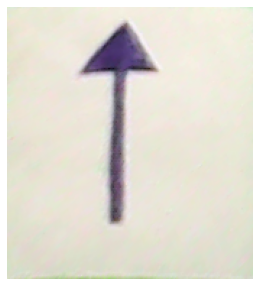

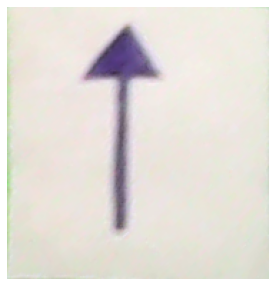

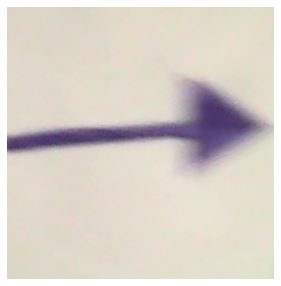

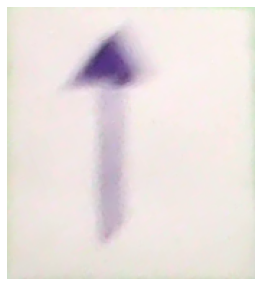

In [70]:
warped = []
i = 0
for fname in files:
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    contour = find_contour(img, low_th, high_th)
    img_w = four_point_transform (img, np.asarray (contour) [:, 0, :])
    warped.append(img_w)
    plt.imshow (warped[i])
    plt.axis ('off')
    plt.show ()
    i += 1

## Реализуйте определение направления, в котором указывает стрелка.
 ( Не выполняется)

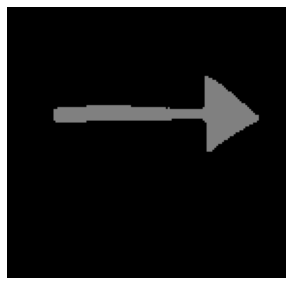

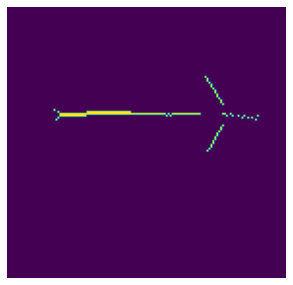

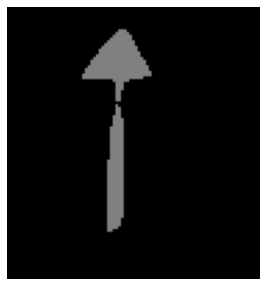

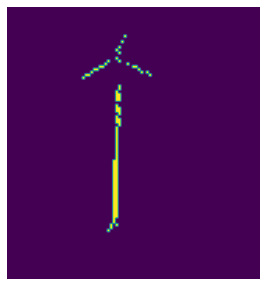

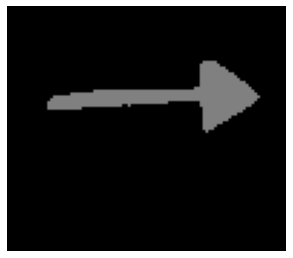

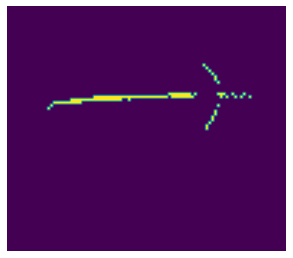

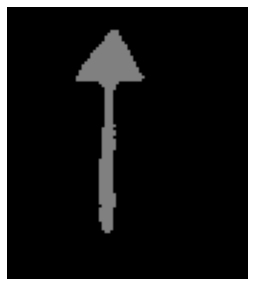

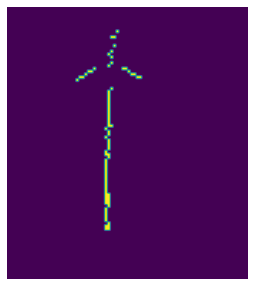

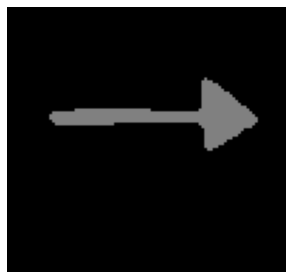

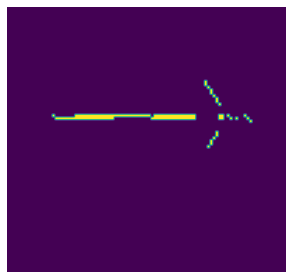

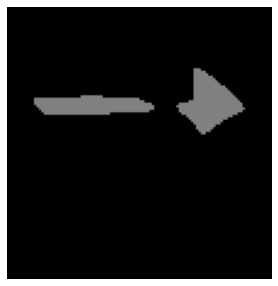

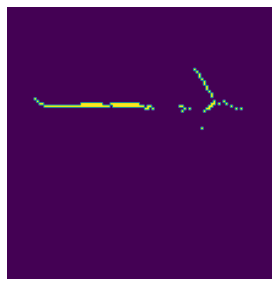

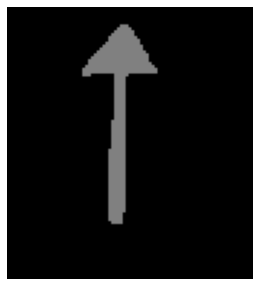

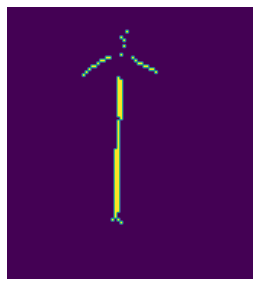

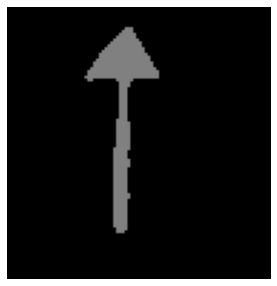

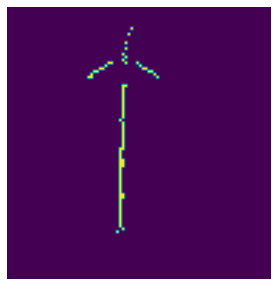

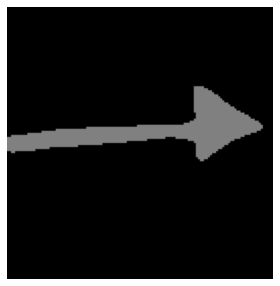

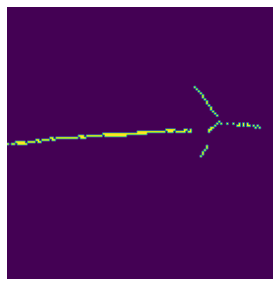

In [73]:
k = 0
for k in range(len(warped) - 1):
  #Detection of blue color

  im_rgb = cv2.pyrDown(warped[k])
  im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)
  im = cv2.adaptiveThreshold(im_gray, 128, cv2.ADAPTIVE_THRESH_MEAN_C,  cv2.THRESH_BINARY_INV, 41, 30)
  im_verbose = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
  plt.imshow(im_verbose)
  plt.axis('off')
  plt.show()
  
  # Doing skeletonisation
  size = np.size(im)
  skel = np.zeros(im.shape,np.uint8)
  ret,im = cv2.threshold(im,127,255,0)

  USE_OPENCV_CONTRIB = 0 

  
  if USE_OPENCV_CONTRIB:
      
      skel = cv2.ximgproc.thinning(im)
  else:
      
      element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
      done = False
      while( not done):
          eroded = cv2.erode(im,element)
          temp = cv2.dilate(eroded,element)
          temp = cv2.subtract(im,temp)
          skel = cv2.bitwise_or(skel,temp)
          im = eroded.copy()

          zeros = size - cv2.countNonZero(im)
          if zeros==size:
              done = True

  plt.imshow(skel)
  plt.axis('off')
  plt.show()
